# 팩터 모델을 활용한 포트폴리오 리스크 계산

팩터 모델을 활용해 포트폴리오 리스크를 구해봅시다.

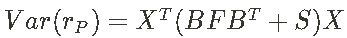

삼성전자, 카카오 2개의 주식만을 Stock Universe로 하는 간단한 포트폴리오를 통해 감을 익혀봅니다

## 1. 데이터 준비

pykrx로부터 2021/01/01 기준 상장된 모든 종목의 5년치 종가 데이터를 불러오고 로그 리턴값으로 변환해줍니다.

그 중에서도 삼성전자와 카카오를 따로 뽑아 asset_return_df라는 변수에 바인딩해줍니다

In [ ]:
from pykrx import stock
import pandas as pd
import numpy as np

In [ ]:
# 약 1분 30초 정도 소요됩니다
tickers = stock.get_market_ticker_list("20210101")
price_df = pd.DataFrame()

for stock_code in tickers:
    price = stock.get_market_ohlcv_by_date("20150101", "20210101", stock_code)['종가']
    price_df[stock_code] = price

# 로그 수익률을 구하고 fillna(0)을 통해 결측치 값은 '수익률 0'으로 채워줍니다
returns_df = (np.log(price_df)-np.log(price_df.shift(1)))[1:].fillna(0)

In [ ]:
# 우리가 사용할 포트폴리오
asset_return_df = returns_df[['005930', '035720']]
삼성전자_asset_return_df = asset_return_df['005930']
카카오_asset_return_df = asset_return_df['035720']

asset_return_df.head()

## 2. Factor Returns(f) 구하기

Risk Factor로 어떤 것을 쓸지 정하고, 해당 팩터 값(f)의 공분산 행렬(F)를 구해야합니다.

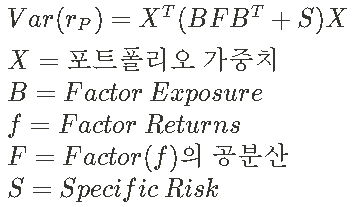

이번 실습에서는 시장 전반의 움직임을 포착하는 Risk Factor로 1. 일별 시장 수익률 평균, 2. 일별 시장 수익률 중앙값을 사용합니다. 우리는 다음 세션에서 이 Risk Factor를 통계적으로 추출하는 방법에 대해 배울것입니다. 
 
지난 포트폴리오 이론 세션에서 배운 '자본자산 가격결정모형(CAPM)'을 잠시 참고하자면

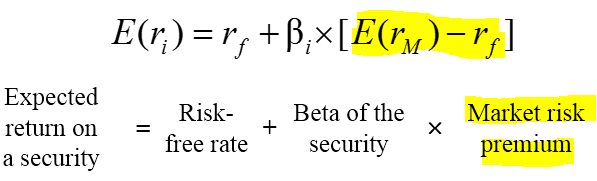

CAPM역시 무위험 자산$\textrm(r_{f})$을 초과하는 시장 수익률$\textrm(Market Risk Premium)$을 팩터값으로 사용하고 이를 바탕으로 $\textrm Beta$를 추정하려는 것을 볼 수 있습니다. CAPM은 $\textrm Market Risk Premium$이란 팩터를 사용하는 단일 팩터 모델이기도 합니다. 이 CAPM에서 발전한 것이 Fama-French의 3 Factor Model, 즉 다중 팩터 모델입니다.

cf) CAPM이 뭔지 잘 모르겠다면? https://m.blog.naver.com/PostView.nhn?blogId=carrot_1027&logNo=220780295571&proxyReferer=https:%2F%2Fwww.google.com%2F

Risk Factor로 사용할 일별 시장 수익률 평균, 일별 시장 수익률 중앙값을 구해봅시다. '일별'데이터이기 때문에 axis=1으로 설정해야 합니다.

In [ ]:
factor_return_1 = returns_df.mean(axis=1)
factor_return_2 = returns_df.median(axis=1)
factor_return = [factor_return_1, factor_return_2]

## 3. Factor Exposure(B) 구하기

각 주식별로 Risk Factor에 대해 고유의 Factor Exposure(B)를 갖게 됩니다. 다시 말해, B는 곧 그 주식의 특성입니다. 선형회귀분석을 통해 주식별 B를 추정해보겠습니다.

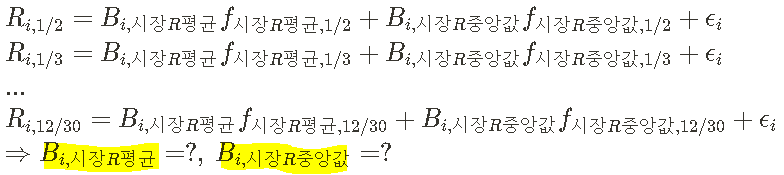

In [ ]:
from sklearn.linear_model import LinearRegression

def get_factor_exposures(factor_return, asset_return):
    lr = LinearRegression()
    f = np.array(factor_return).T
    R = np.array(asset_return.values)
    lr.fit(f,R)
    return lr.coef_

In [ ]:
factor_exposure = []

for i in asset_return_df.columns:
    factor_exposure.append(get_factor_exposures(factor_return,asset_return_df[i]))
    
factor_exposure = np.array(factor_exposure)

In [ ]:
print(factor_exposure, '\n')
print(f"삼성전자의 factor exposure : {factor_exposure[0]}")
print(f"카카오의 factor exposure : {factor_exposure[1]}")

## 삼성전자의 Variance

아래의 공식을 이용하여 삼성전자 주가 수익률의 분산을 계산하세요. 

(팩터 모델을 사용한 분산이 아래와 같이 도출되는 이유는 세션에서 설명하였습니다.)

$\textrm{Var}(r_{1}) = \beta_{1,1}^2 \textrm{Var}(f_{1}) + \beta_{1,2}^2 \textrm{Var}(f_{2}) + 2\beta_{1,1}\beta_{1,2}\textrm{Cov}(f_{1},f_{2}) + \textrm{Var}(s_{1})$

In [ ]:
삼성전자_factor_exposure_1 = factor_exposure[0][0]
삼성전자_factor_exposure_2 = factor_exposure[0][1]

# common_return은 Risk Factor로 설명되는 수익률, specific_return은 설명되지 않는 그 외의 수익률입니다
삼성전자_common_return = 삼성전자_factor_exposure_1 * factor_return_1 + 삼성전자_factor_exposure_2 * factor_return_2
삼성전자_specific_return = 삼성전자_asset_return_df - 삼성전자_common_return

$\mathbf{F}= \begin{pmatrix}
\textrm{Var}(f_1) & \textrm{Cov}(f_1,f_2) \\ 
\textrm{Cov}(f_2,f_1) & \textrm{Var}(f_2) 
\end{pmatrix}$, $\mathbf{S} = \begin{pmatrix}
\textrm{Var}(s_i) & 0\\ 
0 & \textrm{Var}(s_j)
\end{pmatrix}$

In [ ]:
# Factor Retunrs(f)의 공분산 행렬 F를 구해줍니다
# 이때, 표본 공분산 행렬이므로 (n-1)로 나눠주어야 하며 np.cov(ddof=1)로 설정할 수 있습니다
covm_f1_f2 = np.cov(factor_return_1,factor_return_2,ddof=1) 

# Var(f_1), Var(f_2), Cov(f_1,f_2)를 각각 구해줍니다
var_f1 = covm_f1_f2[0,0]
var_f2 = covm_f1_f2[1,1]
cov_f1_f2 = covm_f1_f2[0][1]

# specific_return의 분산도 구해줍니다 
var_s_1 = np.var(삼성전자_specific_return,ddof=1)

# 위에서 구한 것들을 바탕으로 삼성전자의 분산을 계산합니다
삼성전자_variance= (삼성전자_factor_exposure_1**2 * var_f1) + \
                   (삼성전자_factor_exposure_2**2 * var_f2) + \
              2 * (삼성전자_factor_exposure_1 * 삼성전자_factor_exposure_2 * cov_f1_f2) + \
              var_s_1
print(f"삼성전자의 Variance : {삼성전자_variance:.8f}")

## 카카오의 Variance
카카오의 분산도 계산해봅시다.  

$\textrm{Var}(r_{2}) = \beta_{2,1}^2 \textrm{Var}(f_{1}) + \beta_{2,2}^2 \textrm{Var}(f_{2}) + 2\beta_{2,1}\beta_{2,2}\textrm{Cov}(f_{1},f_{2}) + \textrm{Var}(s_{2})$

In [ ]:
카카오_factor_exposure_1 = factor_exposure[1][0]
카카오_factor_exposure_2 = factor_exposure[1][1]
카카오_common_return = 카카오_factor_exposure_1 * factor_return_1 + 카카오_factor_exposure_2 * factor_return_2
카카오_specific_return = 카카오_asset_return_df - 카카오_common_return

In [ ]:
# 카카오의 분산을 구할 때도 삼성전자의 분산을 구할 때 쓰인 Var(f_1), Var(f_2), Cov(f_1,f_2)가 그대로 쓰입니다
# 이로 인해 빠르게 포트폴리오 리스크를 계산할 수 있는 것입니다
# 따라서 카카오 specific_return의 분산만 구해주면 됩니다. 
var_s_2 = np.var(카카오_specific_return,ddof=1)

# 위에서 구한 것들을 바탕으로 카카오의 분산을 계산합니다
카카오_variance = (카카오_factor_exposure_1**2 * var_f1) + \
                  (카카오_factor_exposure_2**2 * var_f2) + \
                  (2 * 카카오_factor_exposure_1 * 카카오_factor_exposure_2 * cov_f1_f2) + \
                  var_s_2
            
print(f"카카오의 Variance: {카카오_variance:.8f}")

## 삼성전자와 카카오의 Covariance
삼성전자와 카카오의 공분산을 계산할 차례입니다.

$\textrm{Cov}(r_{1},r_{2}) = \beta_{1,1}\beta_{2,1}\textrm{Var}(f_{1}) + \beta_{1,1}\beta_{2,2}\textrm{Cov}(f_{1},f_{2}) + \beta_{1,2}\beta_{2,1}\textrm{Cov}(f_{1},f_{2}) + \beta_{1,2}\beta_{2,2}\textrm{Var}(f_{2})$

In [ ]:
# TODO: calculate the covariance of assets 1 and 2 in terms of the factors
삼성전자_카카오_cov = (삼성전자_factor_exposure_1 * 카카오_factor_exposure_1 * var_f1) + \
                      (삼성전자_factor_exposure_1 * 카카오_factor_exposure_2 * cov_f1_f2) + \
                      (삼성전자_factor_exposure_2 * 카카오_factor_exposure_1 * cov_f1_f2) + \
                      (삼성전자_factor_exposure_2 * 카카오_factor_exposure_2 * var_f2)
print(f"삼성전자와 카카오의 공분산: {삼성전자_카카오_cov:.8f}")

## Quiz 1: 포트폴리오 Variance 계산하기

$\textrm{Var}(r_p) = x_{1}^{2} \textrm{Var}(r_1) + x_{2}^{2} \textrm{Var}(r_2) + 2x_{1}x_{2}\textrm{Cov}(r_{1},r_{2})$ 

원래는 수익은 극대화하면서 분산은 최소화하는 '포트폴리오 가중치'를 portfolio optimization을 통해 구해야합니다. 다만 이번 실습은 팩터모델을 활용했을 때 포트폴리오의 Variance가 어떻게 계산되는지를 파악하고자하므로 포트폴리오 가중치가 삼성전자 60%, 카카오 40%로 주어졌다고 합시다

포트폴리오의 분산을 구해 portfolio_variance 변수에 담아주세요.

In [ ]:
삼성전자_가중치 = 0.60
카카오_가중치 = 0.40

# 포트폴리오 분산을 구해주세요

portfolio_variance = # TO DO...
print(f"포트폴리오 Variance : {portfolio_variance:.8f}")

## Quiz 2: 행렬로 계산하기

아래의 식을 참고하여 행렬로 포트폴리오 분산을 계산하세요

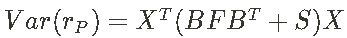

$\mathbf{F}= \begin{pmatrix}
\textrm{Var}(f_1) & \textrm{Cov}(f_1,f_2) \\ 
\textrm{Cov}(f_2,f_1) & \textrm{Var}(f_2) 
\end{pmatrix}$
는 Factor Returns(f)의 공분산 행렬입니다.

$\mathbf{B} = \begin{pmatrix}
\beta_{1,1}, \beta_{1,2}\\ 
\beta_{2,1}, \beta_{2,2}
\end{pmatrix}$ 
는 Factor Exposure를 나타내는 행렬입니다. 

$\mathbf{S} = \begin{pmatrix}
\textrm{Var}(s_i) & 0\\ 
0 & \textrm{Var}(s_j)
\end{pmatrix}$
는 Specific_Risk를 나타내는 대각행렬입니다. $\textrm{Var}(s_i)$와 $\textrm{Var}(s_j)$를 대각행렬을 만드는 이유는 행렬 계산을 위해서입니다.  

$\mathbf{X} = \begin{pmatrix}
x_{1} \\
x_{2}
\end{pmatrix}$는 포트폴리오 가중치 벡터입니다.

In [ ]:
F = # TO DO...
F

In [ ]:
B = # TO DO...
B

In [ ]:
S = # TO DO...
S

In [ ]:
# 가중치 행렬 X의 형태는 (2,1)의 컬럼 벡터여야 합니다
X = # TO DO...
X

In [ ]:
portfolio_variance = # TO DO...

print(f"포트폴리오 Variance : {portfolio_variance[0][0]:.8f}")

In [ ]:
# 일별 데이터를 바탕으로 계산된 포트폴리오 분산이므로, 표준편차로 변환하고 이를 연율화(Annualization) 시켜주세요
annualized_portfolio_variance = # TO DO...

print(f"연율화된 포트폴리오 변동성(표준편차표준편차) : {annualized_portfolio_variance:.8f}")